In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision import models
from fastai.vision import *

import PIL.Image

use_gpu = torch.cuda.is_available()
use_gpu

True

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
pathFileTrain = 'train50000.csv'
pathFileValid = 'valid.csv'

# Neural network parameters:
nnClassCount = 14                   #dimension of the output

# Training settings: batch size
trBatchSize = 64

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (255, 255)
imgtransCrop = 224

## 1. Create Dataset
We create our dataset from a csv file which includes image names and mask of each image. Each mask includes 14 different types of pathologies. It's possible that each image has more than one pathologies, indicating we use multi-hot encoding in this project.<br><br>
_Mask Type:_
* Blanks (''): the existence of the pathology is unknown.
* Ones (1): the pathology is detected thanks to the image.
* Zeros (0): the pathology can't be detected thanks to the image.
* Uncertain (-1): the pathology may be detected.

_Policies:_
* ones: seeing all the uncertain pathologies as positive
* zeros: seeing all the uncertain pathologies as negative

In [5]:
class CheXpertDataSet(Dataset):
    def __init__(self, image_list_file, transform=None, policy="ones"):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels
        """
        x = []
        y = []

        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                image_name= line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                x.append('../' + image_name)
                y.append(label)

        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.x[index]
        # image = Image.open(image_name).convert('RGB')
        image = PIL.Image.open(image_name).convert('RGB')
        label = self.y[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.LongTensor(label)

    def __len__(self):
        return len(self.x)

## 2. Create DataLoaders

First we define a transform model to resize all images and normalize them.

In [6]:
#TRANSFORM DATA

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
transformList.append(transforms.Resize(imgtransResize))
transformList.append(transforms.RandomResizedCrop(imgtransCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence = transforms.Compose(transformList)

In [7]:
# Create subclass of databunch for cnn_learner use

class MyDataBunch(DataBunch):
  def __init__(self, train_dl:DataLoader, valid_dl:DataLoader, fix_dl:DataLoader=None, test_dl:Optional[DataLoader]=None,
                 device:torch.device=None, dl_tfms:Optional[Collection[Callable]]=None, path:PathOrStr='.',
                 collate_fn:Callable=data_collate, no_check:bool=False, c=2):
    DataBunch.__init__(self, train_dl, valid_dl, fix_dl=None, test_dl=None,
                 device=None, dl_tfms=None, path='.',
                 collate_fn=data_collate, no_check=False)
    
    self.c = c
  
  @classmethod
  def create(cls, train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None, path:PathOrStr='.', bs:int=64,
               val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None,
               device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False, c=2, **dl_kwargs)->'DataBunch':
        "Create a `DataBunch` from `train_ds`, `valid_ds` and maybe `test_ds` with a batch size of `bs`. Passes `**dl_kwargs` to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        dls = [DataLoader(d, b, shuffle=s, drop_last=s, num_workers=num_workers, **dl_kwargs) for d,b,s in
               zip(datasets, (bs,val_bs,val_bs,val_bs), (True,False,False,False)) if d is not None]
        return cls(*dls, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check, c=c)

Then we build train, validation and test data loaders. 

In [8]:
#LOAD DATASET

train_ds = CheXpertDataSet(pathFileTrain ,transformSequence, policy="ones")
valid_ds = CheXpertDataSet(pathFileValid, transformSequence)   

# Create dataloaders
dataloaderTrain = DataLoader(dataset=train_ds, batch_size=trBatchSize, shuffle=True)
dataloaderValid = DataLoader(dataset=valid_ds, batch_size=trBatchSize, shuffle=False)

# Create databunch
data = MyDataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=trBatchSize, c=nnClassCount)

In [9]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [10]:
images, labels = next(iter(dataloaderValid))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


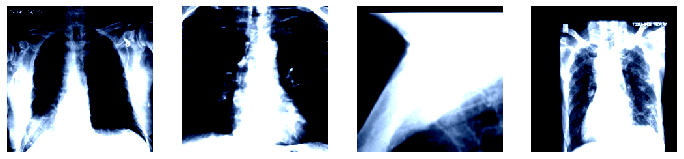

In [11]:
fig, axes = plt.subplots(figsize=(12,9), ncols=4)
for ii in range(4):
  ax = axes[ii]
  imshow(images[ii], ax=ax, normalize=False)

## 3. Create Architecture and Train Model

Create an architecture of resnet50, find the best learning rate, and train the model using best slice learning rates.

In [ ]:
# fastai

In [12]:
arch = models.resnet50

In [13]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])
learn.loss_func = BCEWithLogitsFlat()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


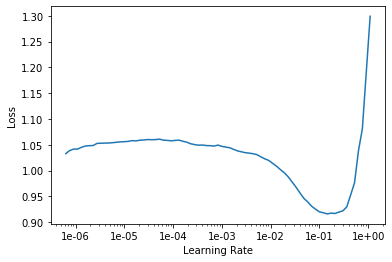

In [15]:
learn.recorder.plot()

In [16]:
lr = 0.03

In [17]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.409358,0.409093,0.750610,0.552286,02:50
1,0.407807,0.406758,0.717949,0.517468,02:46
2,0.396310,0.378443,0.772589,0.577844,02:56
3,0.378183,0.377572,0.785409,0.604669,02:51
4,0.370711,0.381315,0.772894,0.574081,02:51


In [18]:
# Save model before fine tuning
learn.save('stage-1-rn50')

In [19]:
# Fine tune model
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


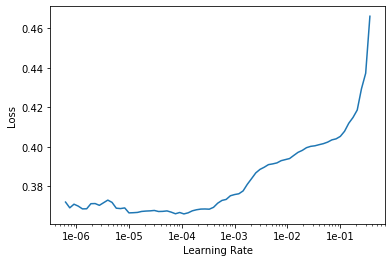

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.378650,0.450442,0.788156,0.575232,03:06
1,0.383189,0.495613,0.770146,0.552178,03:07
2,0.376022,0.369219,0.772283,0.604469,03:07
3,0.368444,0.371852,0.774725,0.597337,03:08
4,0.365860,0.377561,0.784799,0.594255,03:02


In [ ]:
# Save model fine tuned
learn.save('stage-2-rn50')